In [1]:
import warnings
 
# 모든 경고 메시지를 무시합니다.
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import requests
import time
from openai import AzureOpenAI
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()

client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"),
  api_key= os.getenv("AZURE_OPENAI_API_KEY"),
  api_version="2025-01-01-preview"
)


WEATHER_DATA = {
    "tokyo": None,
    "san francisco": None,
    "paris": None,
    "seoul": None
}

# Simplified timezone data
TIMEZONE_DATA = {
    "tokyo": "Asia/Tokyo",
    "san francisco": "America/Los_Angeles",
    "paris": "Europe/Paris",
    "seoul" : "Asia/Seoul"
}

def get_current_weather(location, unit=None):
    """Get the current weather for a given location"""
    location_lower = location.lower()

    # print(f"get_current_weather called with location: {location}, unit: {unit}")  
    
    for key in WEATHER_DATA:
        if key in location_lower:
            # print(f"Weather data found for {key}")  
            # weather = WEATHER_DATA[key]

            geo_url = f"https://geocoding-api.open-meteo.com/v1/search?name={key}&count=1&language=ko"
            geo = requests.get(geo_url).json()

            lat, lon = geo['results'][0]['latitude'], geo['results'][0]['longitude']

            weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current=temperature_2m,relative_humidity_2m,weather_code,rain,precipitation,wind_speed_10m,wind_direction_10m"
            data = requests.get(weather_url).json()

            return json.dumps({
                "location": location,
                "temperature": data["current"]["temperature_2m"],
                "relative_humidity": data["current"]["relative_humidity_2m"],
                "weather_code": data["current"]["weather_code"],
                "rain": data["current"]["rain"],
                "precipitation": data["current"]["precipitation"],
                "wind_speed": data["current"]["wind_speed_10m"],
                "wind_direction": data["current"]["wind_direction_10m"],
                "unit": None
            })
    
    # print(f"No weather data found for {location_lower}")  
    return json.dumps({"location": location, "temperature": "unknown"})

def get_current_time(location):
    """Get the current time for a given location"""
    print(f"get_current_time called with location: {location}")  
    location_lower = location.lower()
    
    for key, timezone in TIMEZONE_DATA.items():
        if key in location_lower:
            # print(f"Timezone found for {key}")  
            current_time = datetime.now(ZoneInfo(timezone)).strftime("%I:%M %p")
            return json.dumps({
                "location": location,
                "current_time": current_time
            })
    
    # print(f"No timezone data found for {location_lower}")  
    return json.dumps({"location": location, "current_time": "unknown"})

def chatbot_integ(input_text) :
    assistant = client.beta.assistants.create(
        model="gpt-4o-mini", # replace with model deployment name.
        instructions="당신은 여러가지 정보를 제공하는 챗봇입니다.",
        tools = [
            {
                "type": "function",
                "function": {
                    "name": "get_current_weather",
                    "description": "Get the current weather in a given location",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "location": {
                                "type": "string",
                                "description": "The city name, e.g. San Francisco MUST be translated into English",
                            },
                            "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
                        },
                        "required": ["location"],
                    },
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "get_current_time",
                    "description": "Get the current time in a given location",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "location": {
                                "type": "string",
                                "description": "The city name, e.g. San Francisco MUST be translated into English",
                            },
                        },
                        "required": ["location"],
                    },
                }
            },
            {"type":"code_interpreter"},
            {"type":"file_search"}
        ],
        tool_resources={},
        temperature=1,
        top_p=1
    )

    # Create a thread
    thread = client.beta.threads.create()

    # 로컬 파일 읽어와서 임시 벡터 저장소로 보내는 코드
    file_path = "C:/workspace/mslearn-openai/Labfiles/personal-exer/files/파일읽기 예시pdf.pdf"

    message_file = client.files.create(
        file=open(file_path, 'rb'),
        purpose='assistants'
    )

    # Add a user question to the thread
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=input_text
    )

    # Run the thread
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id
    )

    # Looping until the run completes or fails
    while run.status in ['queued', 'in_progress', 'cancelling']:
    
        time.sleep(1)
        run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
        )

        if run.status == 'completed':
            messages = client.beta.threads.messages.list(
            thread_id=thread.id
            )

            for content in  messages.data[0].content :
                if content.type == "text" :
                    print(content.text.value)

                elif content.type == "image_file" :
                    image_id = content.image_file.file_id
                    image_data = client.files.content(image_id).read()
                    display(Image(image_data))

        elif run.status == 'requires_action':

            tool_outputs = []

            for tool_call in run.required_action.submit_tool_outputs.tool_calls :
                function_name = tool_call.function.name
                function_args = json.loads(tool_call.function.arguments)
                # print(f"Function call: {function_name}")  
                # print(f"Function arguments: {function_args}")  
                
                if function_name == "get_current_weather" :
                    output = get_current_weather(
                        location=function_args.get("location"),
                        unit=function_args.get("unit")
                    )
                    tool_outputs.append({"tool_call_id": tool_call.id, "output": output})
                elif function_name == "get_current_time":
                    function_response = get_current_time(
                        location=function_args.get("location")
                    )
                    tool_outputs.append({"tool_call_id": tool_call.id, "output": output})
                else:
                    function_response = json.dumps({"error": "Unknown function"})
                    
            run = client.beta.threads.runs.submit_tool_outputs(
                thread_id=thread.id,
                run_id=run.id,
                tool_outputs=tool_outputs
            )


파이썬(Python)은 간결하고 가독성이 높은 프로그래밍 언어로, 다양한 분야에서 사용됩니다. 기본적인 파이썬 문법을 다음과 같이 소개합니다.

### 1. 변수와 데이터 타입
파이썬은 변수 선언 시 자료형을 명시하지 않습니다. 변수에 값을 할당하는 것으로 자료형이 결정됩니다.

```python
# 정수형
int_var = 10

# 실수형
float_var = 10.5

# 문자열
str_var = "Hello, Python!"

# 불리언
bool_var = True
```

### 2. 리스트
리스트는 여러 값을 저장할 수 있는 자료형입니다.

```python
my_list = [1, 2, 3, 4, 5]
```

### 3. 조건문
`if` 문을 사용하여 조건에 따라 실행할 코드 블록을 결정할 수 있습니다.

```python
if int_var > 5:
    print("변수는 5보다 큽니다.")
elif int_var == 5:
    print("변수는 5입니다.")
else:
    print("변수는 5보다 작습니다.")
```

### 4. 반복문
`for`와 `while` 문을 사용하여 반복적으로 코드를 실행할 수 있습니다.

```python
# for 문
for i in range(5):
    print(i)

# while 문
count = 0
while count < 5:
    print(count)
    count += 1
```

### 5. 함수
함수는 재사용할 수 있는 코드 블록입니다.

```python
def greet(name):
    return f"안녕하세요, {name}!"

print(greet("홍길동"))
```

### 6. 클래스
파이썬은 객체 지향 프로그래밍을 지원합니다.

```python
class Dog:
    def __init__(self, name):
        self.name = name

    def bark(self):
        return f"{self.name

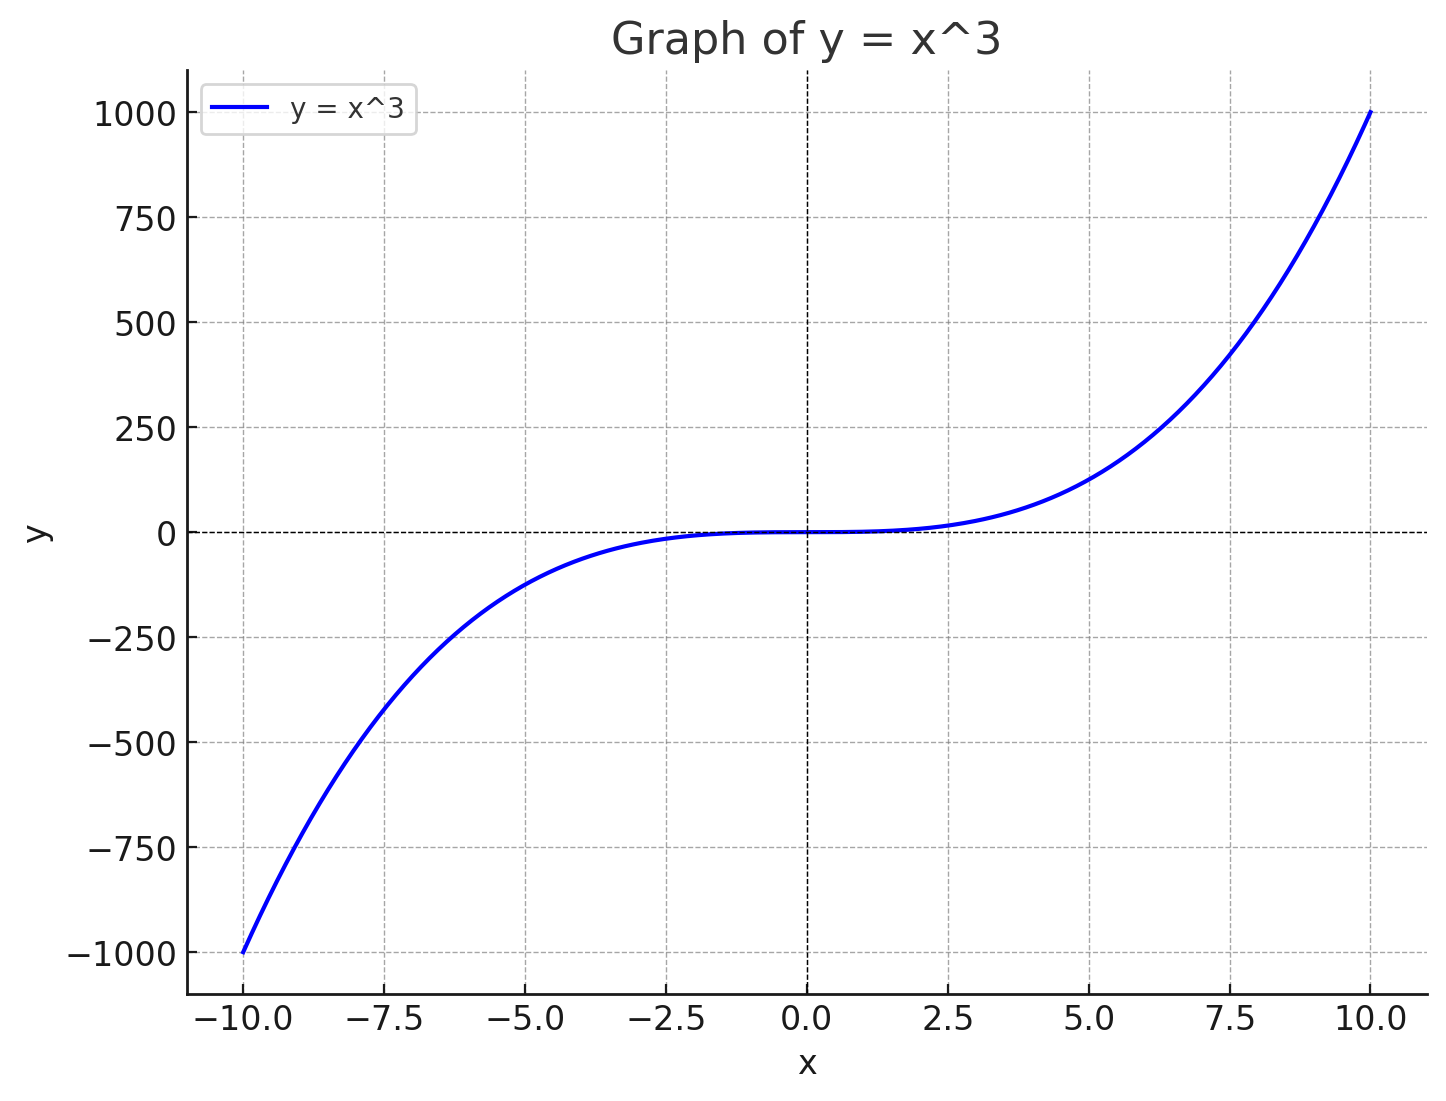

여기 \( y = x^3 \)의 그래프가 있습니다. 그래프는 x의 값에 따라 y 값이 어떻게 변화하는지를 보여주며, 좌측에서 우측으로 갈수록 급격히 증가합니다. 이 함수는 x가 증가할 때 y가 큽니다. 반대로, x가 감소할 때 y는 음의 방향으로 내려갑니다.


In [4]:
chatbot_integ("파이썬 문법에 대해서 알려줄래?")
chatbot_integ("그러면, y=x^3 의 그래프를 그려줄래?")